In [1]:
import os
import struct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader


plt.style.use('seaborn-v0_8')
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)


## Load MNIST

In [2]:
DATASET_PATH = os.path.join(os.environ['DL_DATASET'],"EMNIST", "emnist_source_files")
os.listdir(DATASET_PATH)

['emnist-digits-train-images-idx3-ubyte',
 'emnist-byclass-test-labels-idx1-ubyte',
 'emnist-letters-train-labels-idx1-ubyte',
 'emnist-letters-test-images-idx3-ubyte',
 'emnist-mnist-train-images-idx3-ubyte',
 'emnist-byclass-train-labels-idx1-ubyte',
 'emnist-bymerge-test-labels-idx1-ubyte',
 'emnist-letters-test-labels-idx1-ubyte',
 'emnist-balanced-test-labels-idx1-ubyte',
 'emnist-digits-train-labels-idx1-ubyte',
 'emnist-bymerge-test-images-idx3-ubyte',
 'emnist-byclass-train-images-idx3-ubyte',
 'emnist-balanced-test-images-idx3-ubyte',
 'emnist-bymerge-train-labels-idx1-ubyte',
 'emnist-balanced-train-labels-idx1-ubyte',
 'emnist-byclass-test-images-idx3-ubyte',
 'emnist-bymerge-train-images-idx3-ubyte',
 'emnist-letters-train-images-idx3-ubyte',
 'emnist-mnist-test-images-idx3-ubyte',
 'emnist-mnist-test-labels-idx1-ubyte',
 'emnist-digits-test-labels-idx1-ubyte',
 'emnist-mnist-train-labels-idx1-ubyte',
 'emnist-balanced-train-images-idx3-ubyte',
 'emnist-digits-test-images-i

In [3]:
def load_mnist(path, which='train'):
 
    if which == 'train':
        labels_path = os.path.join(path, 'emnist-digits-train-labels-idx1-ubyte')
        images_path = os.path.join(path, 'emnist-digits-train-images-idx3-ubyte')
    elif which == 'test':
        labels_path = os.path.join(path, 'emnist-digits-test-labels-idx1-ubyte')
        images_path = os.path.join(path, 'emnist-digits-test-images-idx3-ubyte')
    else:
        raise AttributeError('`which` must be "train" or "test"')
        
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)

    with open(images_path, 'rb') as imgpath:
        magic, n, rows, cols = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(len(labels), 784)
    images = images.reshape(-1, int(np.sqrt(images.shape[1])), int(np.sqrt(images.shape[1])))
    return images, labels

In [4]:
images, labels = load_mnist(os.path.join(DATASET_PATH, ))

In [5]:
images.shape

(240000, 28, 28)

In [6]:
labels.shape

(240000,)

In [4]:
def plot_images(img, label):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='viridis')
    ax.set_title("Label: {}".format(label))


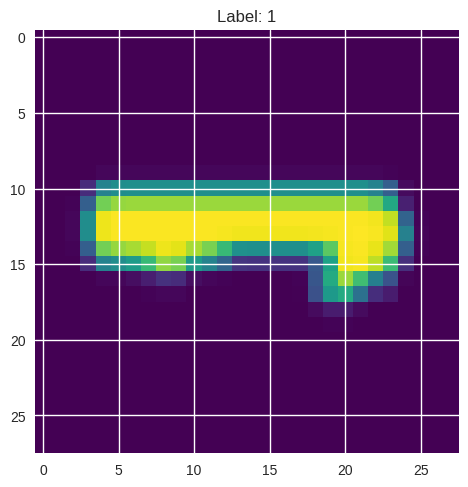

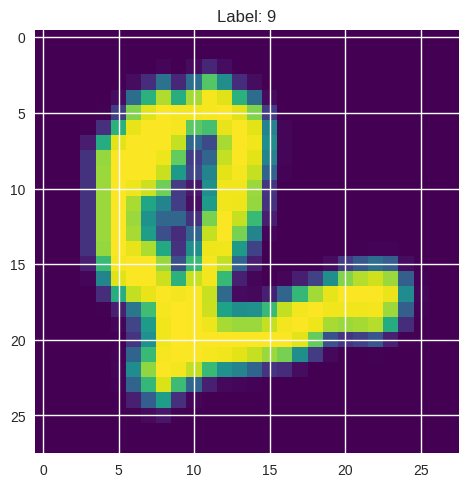

In [8]:
for i in random.sample(range(images.shape[0]), 2):
    plot_images(images[i], labels[i])

## Dataloader

In [5]:
class MNISTDataset(Dataset):
    
    def __init__(self, dataset_path, train_test_name) -> None:
        self.images, self.labels = load_mnist(dataset_path, train_test_name)
    
    def __getitem__(self, index):
        img = self.images[index].astype(np.float32)
        label = self.labels[index]
        img /= 255.
        return img, label
    
    def __len__(self):
        return len(self.images)
    

In [10]:
train_mnist_dataset = MNISTDataset(DATASET_PATH, "train")

In [11]:
test_mnist_dataset = MNISTDataset(DATASET_PATH, "test")

In [12]:
batch_size = 32
num_workers = 4

In [13]:
dataloader = DataLoader(train_mnist_dataset, batch_size=batch_size, shuffle=True, 
                        num_workers=num_workers)

## Model

In [6]:
class MLP(nn.Module):
    def __init__(self, in_features=28*28, out_features=10):
        super().__init__()
        h1, h2 = 400, 200
        self.net = nn.Sequential(
            nn.Linear(in_features, h1),
            nn.ReLU(),
            nn.Dropout(), 
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Dropout(), 
            nn.Linear(h2, out_features)
        )
        self.apply(self.reset_parameters)
    
    @staticmethod
    def reset_parameters(module):
        if isinstance(module, nn.Linear):
            print("Initializing the models parameters")
            with torch.no_grad():
                module.weight.data.uniform_(-0.1, 0.1)
                if module.bias is not None:
                    module.bias.data.zero_()
    
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.net(x)
        return x

In [15]:
model = MLP()

Initializing the models parameters
Initializing the models parameters
Initializing the models parameters


In [16]:
loss_fn = nn.CrossEntropyLoss()

## Config

In [7]:
class Config:
    num_epochs = 50
    batch_size = 2048 * 8
    num_workers = 10
    eval_iter = 1
    savepath = '/mnt/dl/mnist'
    print_every =  250
    

## Trainer

In [8]:
class Trainer:
    
    def __init__(self, cfg, model, train_loader, test_loader, loss_fn, optimizer, scheduler=None) -> None:
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.num_epochs = cfg.num_epochs
        self.batch_size = cfg.batch_size
        self.num_workers = cfg.num_workers
        self.device = next(self.model.parameters())[0].device
        self.savepath = cfg.savepath
        self.eval_iter = cfg.eval_iter
        self.print_every = cfg.print_every
        self.start_epoch = cfg.start_epoch if hasattr(cfg, 'start_epoch') else 0
        os.makedirs(self.savepath, exist_ok=True)
    
    def train(self):
        if not hasattr(self, 'train_losses'):
            self.train_losses, self.val_losses = [], []
            self.best_loss = float('-inf')
        iters = 0        
        self.model.train()
        for i in range(self.start_epoch, self.num_epochs):
            for j, (img, label) in enumerate(self.train_loader):
                img, label = img.to(self.device), label.to(self.device)
                out = self.model(img)
                loss = self.loss_fn(out, label)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.train_losses.append(loss.item())
                # if j == 10:
                #     break
                if iters % self.print_every == 0:
                    print(f'It: {iters}, Epochs: {i} ,loss: {loss.item()} ')
                iters += 1
                
                
            if self.scheduler is not None:
                self.scheduler.step()
            
            if i > 0 and self.eval_iter and i % self.eval_iter == 0:
                self.val_losses.append(self.validate(self.test_loader))
                if self.val_losses[-1] > self.best_loss:
                    self.save(f"{self.checkpoint}best.pth", {
                                "model": self.model.state_dict(),
                                "optimizer": self.optimizer.state_dict(),
                                "scheduler": self.scheduler.state_dict() if self.scheduler is not None else {},
                                "train_losses": self.train_losses,
                                "val_losses": self.val_losses,
                                "epoch": i,
                                "best_loss": self.best_loss,
                            })
                    self.best_loss = self.val_losses[-1]
                    print(f'Epochs: {i} , Best loss: {self.best_loss} ')

                
        
        self.save(f"{self.checkpoint}{i}.pth", {
            "model": self.model.state_dict(),
            "optimizer": self.optimizer.state_dict(),
            "scheduler": self.scheduler.state_dict() if self.scheduler is not None else {},
            "train_losses": self.train_losses,
            "val_losses": self.val_losses,
            "best_loss": self.best_loss,
            "epoch": i,
        })
        
        return 


    @property
    def checkpoint(self):
        return "checkpoint"
                
    def validate(self, loader):
        self.model.eval()
        acc = []
        with torch.no_grad():
            for _, (img, label) in enumerate(loader):
                img, label = img.to(self.device), label.to(self.device)
                out = self.model(img)
                out = torch.softmax(out, dim=-1)
                out_max_idx = torch.argmax(out, -1)
                batch_acc = (out_max_idx == label).sum().float() / out.size(0)
                batch_acc = batch_acc.detach().item()
                acc.append(batch_acc)
        return np.mean(acc)

    def save(self, checkpoint, state):
        savefname = os.path.join(self.savepath, checkpoint,)
        torch.save(state, savefname)
    
    def load(self, checkpoint):
        print("Loading...")
        state = torch.load(os.path.join(self.savepath, checkpoint))
        self.model.load_state_dict(state['model'])
        self.optimizer.load_state_dict(state['optimizer'])
        if self.scheduler:
            self.scheduler.load_state_dict(state.get('scheduler', {}))
        self.train_losses = state['train_losses']
        self.val_losses = state['val_losses']
        self.best_loss = state['best_loss']
        self.start_epoch = state['epoch']
        print("Starting from {}".format(self.start_epoch))
        
        return True
            

In [19]:
def run(checkpoint=None):
    train_mnist_dataset = MNISTDataset(DATASET_PATH, "train")
    test_mnist_dataset = MNISTDataset(DATASET_PATH, "test")
    train_loader = DataLoader(train_mnist_dataset, batch_size=Config.batch_size, shuffle=True, 
                            num_workers=Config.num_workers)
    test_loader = DataLoader(test_mnist_dataset, batch_size=Config.batch_size)
    model = MLP()

    loss_fn = nn.CrossEntropyLoss()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    
    model.cuda()
    
    trainer = Trainer(Config, model, train_loader, test_loader, loss_fn, optimizer, )
    if checkpoint is not None:
        trainer.load(checkpoint)
    trainer.train()
    return trainer

In [20]:
# run("checkpointbest.pth")
trainer = run()

Initializing the models parameters
Initializing the models parameters
Initializing the models parameters
It: 0, Epochs: 0 ,loss: 2.4721932411193848 
Epochs: 1 , Best loss: 0.916722297668457 
Epochs: 2 , Best loss: 0.9420758287111918 
Epochs: 3 , Best loss: 0.9547760089238485 
Epochs: 4 , Best loss: 0.9631824692090353 
Epochs: 5 , Best loss: 0.9679329593976339 
Epochs: 6 , Best loss: 0.9720664223035177 
Epochs: 7 , Best loss: 0.975178857644399 
Epochs: 8 , Best loss: 0.977085530757904 
Epochs: 9 , Best loss: 0.9790287415186564 
Epochs: 10 , Best loss: 0.9805937012036642 
Epochs: 11 , Best loss: 0.9820012847582499 
Epochs: 12 , Best loss: 0.9829587737719218 
Epochs: 13 , Best loss: 0.9838701486587524 
Epochs: 14 , Best loss: 0.9847948551177979 
Epochs: 15 , Best loss: 0.9858337243398031 
It: 250, Epochs: 16 ,loss: 0.03672768175601959 
Epochs: 16 , Best loss: 0.9859898289044698 
Epochs: 17 , Best loss: 0.986781656742096 
Epochs: 18 , Best loss: 0.9870760242144266 
Epochs: 19 , Best loss: 

In [21]:
trainer

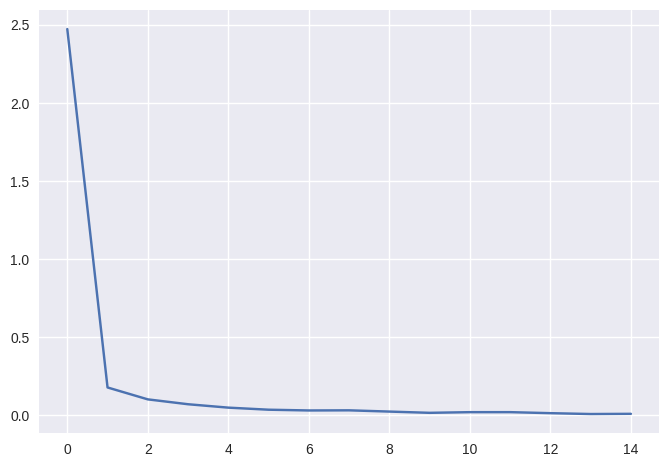

In [22]:
plt.plot(trainer.train_losses[::50])

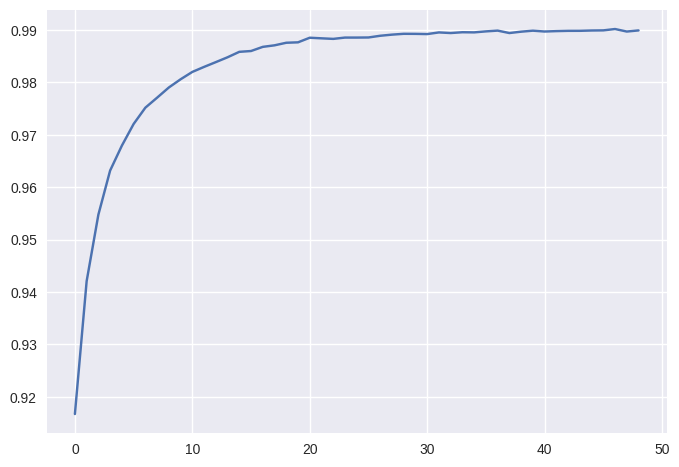

In [23]:
plt.plot(trainer.val_losses[::])

In [24]:
def plot_sample_preds(trainer, sample_num=10):
    model = trainer.model
    model.load_state_dict(torch.load(os.path.join(Config.savepath, "checkpointbest.pth"))['model'])
    model.eval()
    device = trainer.device
    loader = DataLoader(test_mnist_dataset, batch_size=sample_num,)
    with torch.no_grad():
        for _, (img, label) in enumerate(loader):
            img, label = img.to(device), label.to(device)
            out = model(img)
            out = torch.softmax(out, dim=-1)
            out_max_idx = torch.argmax(out, -1)
            img = img * 255.0
            img = img.detach().cpu().numpy()
            label = out_max_idx.detach().cpu().numpy()
            
            for i in range(sample_num):
                plot_images(img[i], label[i])
            break
    model.train()
    

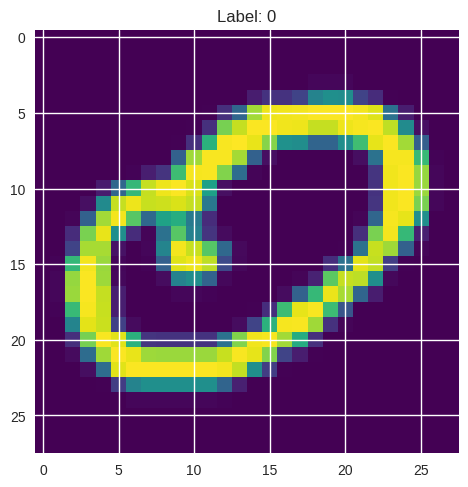

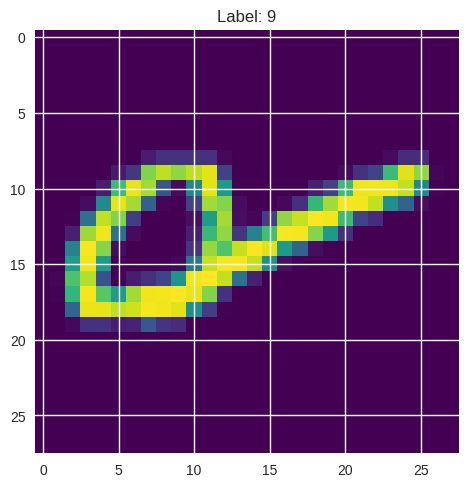

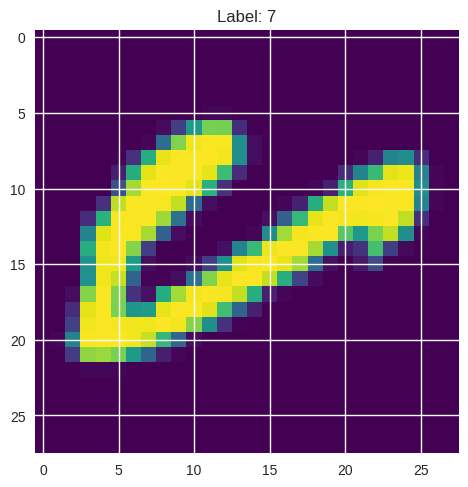

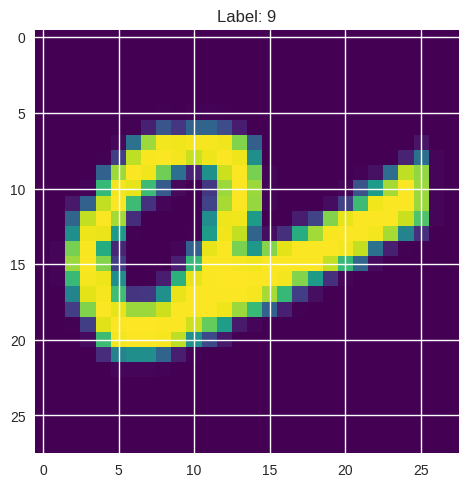

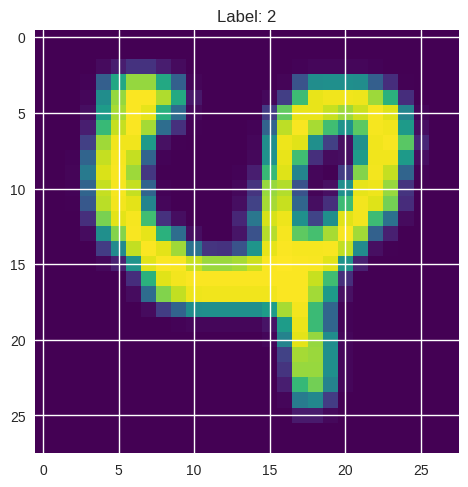

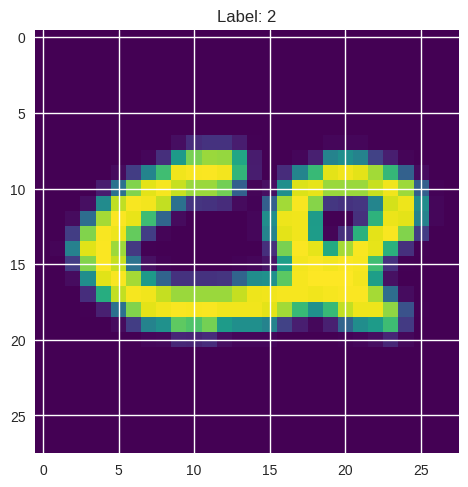

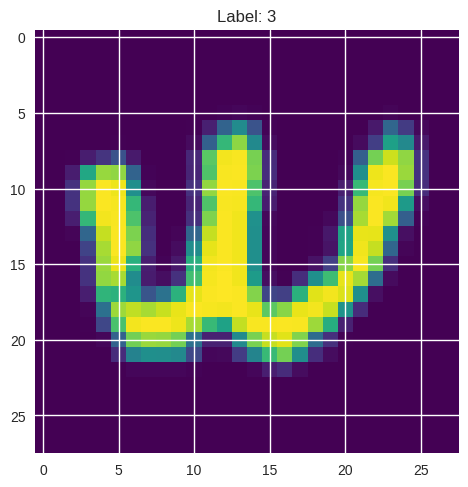

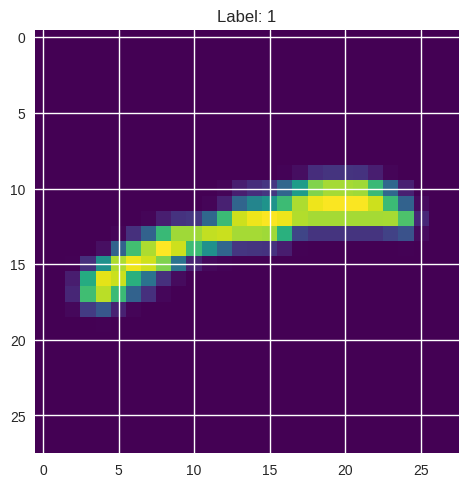

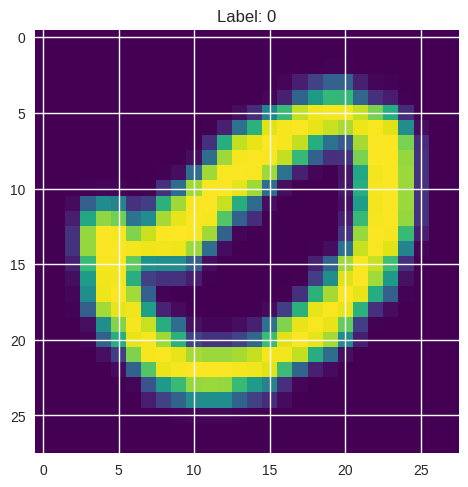

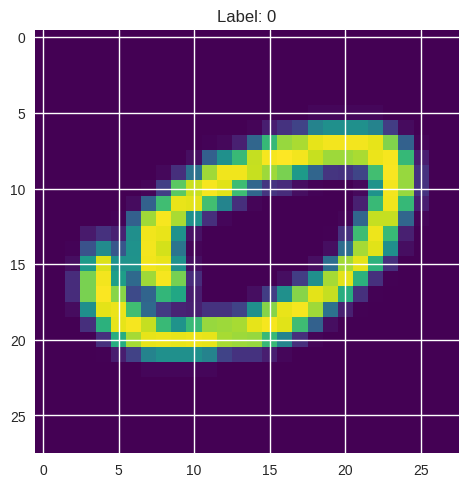

In [25]:
plot_sample_preds(trainer)

In [9]:
from torch.optim.optimizer import _use_grad_for_differentiable
class LAMB(torch.optim.Optimizer):
    
    def __init__(self, params, lr=1e-3, max_norm=10., betas=(0.9, 0.999), 
                 eps=1e-8, weight_decay=0, differentiable=False) -> None:
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay, max_norm=max_norm,
                        eps=eps, differentiable=differentiable)
        if lr < 0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if eps < 0:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        super().__init__(params, defaults=defaults)
    
    def __setstate__(self, state) -> None:
        super().__setstate__(state)
        state_values = list(self.state.values())
        step_is_tensor = (len(state_values) != 0) and torch.is_tensor(state_values[0]['step'])
        if not step_is_tensor:
            for s in state_values:
                s['step'] = torch.tensor(float(s['step']))
    
    @_use_grad_for_differentiable
    def step(self, closure=None):
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        
        for group in self.param_groups:
            self.update(group)
        
        return loss
    
    def update(self, group):
        beta1, beta2 = group['betas']
        lr = group['lr']
        eps = group['eps']
        weight_decay = group['weight_decay']
        max_norm = group['max_norm']
        for param in group['params']:
            if param.grad is not None:
                grad = param.grad
                
                if param not in self.state:
                    exp_avg = torch.zeros_like(param, dtype=param.dtype, device=param.device, memory_format=torch.preserve_format)
                    exp_avg_norm = torch.zeros_like(param, dtype=param.dtype, device=param.device, memory_format=torch.preserve_format)

                    self.state[param]['exp_avg'] = exp_avg
                    self.state[param]['exp_avg_norm'] = exp_avg_norm
                    self.state[param]['steps'] =  torch.tensor(0.)
                                    
                exp_avg = self.state[param]['exp_avg']
                exp_avg_norm = self.state[param]['exp_avg_norm']
                steps = self.state[param]['steps']

                steps += 1
                exp_avg.mul_(beta1).add_(grad, alpha=1-beta1)
                exp_avg_norm.mul_(beta2).add_(grad  * grad, alpha=1-beta2)
                
                bias_correction1 = 1 - beta1 ** steps
                bias_correction2 = 1 - beta2 ** steps
                
                if not torch.is_tensor(bias_correction2):
                    bias_correction2_sqrt = math.sqrt(bias_correction2)
                else:
                    bias_correction2_sqrt = bias_correction2.sqrt()
               
                denom = (exp_avg_norm.sqrt() / bias_correction2_sqrt ) + eps
                numer = exp_avg / bias_correction1
                
                update = numer / denom
                
                if weight_decay != 0:
                    update = update.add(param, alpha=weight_decay)
                
                trust_ratio = 1.0
                param_t_norm = param.norm()
                grad_t_norm = update.norm()
                if param_t_norm > 0 and grad_t_norm > 0:
                    trust_ratio = (param_t_norm / grad_t_norm).clip(max=max_norm)
                
                step_size = trust_ratio * lr
                
                param.add_(-step_size * update)


In [27]:
def run(checkpoint=None, optimizer='adam'):
    print("Testing with Adam")
    train_mnist_dataset = MNISTDataset(DATASET_PATH, "train")
    test_mnist_dataset = MNISTDataset(DATASET_PATH, "test")
    config = deepcopy(Config)
    config.batch_size *= 10
    train_loader = DataLoader(train_mnist_dataset, batch_size=config.batch_size, shuffle=True, 
                            num_workers=config.num_workers)
    test_loader = DataLoader(test_mnist_dataset, batch_size=config.batch_size)
    model = MLP()

    loss_fn = nn.CrossEntropyLoss()
    
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    elif optimizer=='lamb':
        optimizer = LAMB(model.parameters(), lr=1e-1)
    else:
        raise NotImplementedError
    
    model.cuda()
    
    trainer = Trainer(config, model, train_loader, test_loader, loss_fn, optimizer, )
    if checkpoint is not None:
        trainer.load(checkpoint)
    trainer.train()
    return trainer

In [28]:
run(optimizer='adam')

Testing with Adam
Initializing the models parameters
Initializing the models parameters
Initializing the models parameters
It: 0, Epochs: 0 ,loss: 2.4201290607452393 
Epochs: 1 , Best loss: 0.2839750051498413 
Epochs: 2 , Best loss: 0.40164998173713684 
Epochs: 3 , Best loss: 0.49262499809265137 
Epochs: 5 , Best loss: 0.49834999442100525 
Epochs: 6 , Best loss: 0.6177249550819397 
Epochs: 7 , Best loss: 0.6506999731063843 
Epochs: 8 , Best loss: 0.7767750024795532 
Epochs: 9 , Best loss: 0.7936499714851379 
Epochs: 10 , Best loss: 0.8102499842643738 
Epochs: 11 , Best loss: 0.828249990940094 
Epochs: 12 , Best loss: 0.8430999517440796 
Epochs: 13 , Best loss: 0.8596999645233154 
Epochs: 14 , Best loss: 0.8711499571800232 
Epochs: 15 , Best loss: 0.8780999779701233 
Epochs: 16 , Best loss: 0.8842499852180481 
Epochs: 17 , Best loss: 0.8887499570846558 
Epochs: 18 , Best loss: 0.8934749960899353 
Epochs: 19 , Best loss: 0.897849977016449 
Epochs: 20 , Best loss: 0.9019749760627747 
Epoc

In [29]:
run(optimizer='lamb')

Testing with Adam
Initializing the models parameters
Initializing the models parameters
Initializing the models parameters
It: 0, Epochs: 0 ,loss: 2.513598918914795 
Epochs: 1 , Best loss: 0.7175999879837036 
Epochs: 2 , Best loss: 0.7297999858856201 
Epochs: 8 , Best loss: 0.7314499616622925 
Epochs: 10 , Best loss: 0.8173249959945679 
Epochs: 11 , Best loss: 0.818524956703186 
Epochs: 13 , Best loss: 0.8514499664306641 
Epochs: 20 , Best loss: 0.8719499707221985 
Epochs: 21 , Best loss: 0.9086499810218811 
Epochs: 25 , Best loss: 0.9117499589920044 
Epochs: 26 , Best loss: 0.9251999855041504 


In [30]:
run(optimizer='adam')

Testing with Adam
Initializing the models parameters
Initializing the models parameters
Initializing the models parameters
It: 0, Epochs: 0 ,loss: 2.3955936431884766 
Epochs: 1 , Best loss: 0.09999999403953552 
Epochs: 2 , Best loss: 0.1861249953508377 
Epochs: 6 , Best loss: 0.26089999079704285 
Epochs: 9 , Best loss: 0.2680000066757202 
Epochs: 10 , Best loss: 0.3885749876499176 
Epochs: 11 , Best loss: 0.3939249813556671 
Epochs: 15 , Best loss: 0.4175499975681305 
Epochs: 16 , Best loss: 0.4499000012874603 
Epochs: 17 , Best loss: 0.45569998025894165 
Epochs: 18 , Best loss: 0.4702499806880951 
Epochs: 19 , Best loss: 0.48295000195503235 
Epochs: 20 , Best loss: 0.4872249960899353 
Epochs: 21 , Best loss: 0.4894249737262726 
Epochs: 22 , Best loss: 0.492499977350235 
Epochs: 23 , Best loss: 0.5259999632835388 
Epochs: 24 , Best loss: 0.5351499915122986 
Epochs: 25 , Best loss: 0.5539000034332275 
Epochs: 26 , Best loss: 0.5583750009536743 
Epochs: 27 , Best loss: 0.585099995136261 

In [31]:
run(optimizer='lamb')

Testing with Adam
Initializing the models parameters
Initializing the models parameters
Initializing the models parameters
It: 0, Epochs: 0 ,loss: 2.4263007640838623 
Epochs: 1 , Best loss: 0.5860499739646912 
Epochs: 2 , Best loss: 0.6866750121116638 
Epochs: 7 , Best loss: 0.7057749629020691 
Epochs: 8 , Best loss: 0.752424955368042 
Epochs: 10 , Best loss: 0.8002499938011169 
Epochs: 11 , Best loss: 0.8274749517440796 
Epochs: 12 , Best loss: 0.8469749689102173 
Epochs: 13 , Best loss: 0.8762499690055847 
Epochs: 15 , Best loss: 0.877424955368042 
Epochs: 16 , Best loss: 0.9080999493598938 
Epochs: 21 , Best loss: 0.9108999967575073 


In [10]:
def run_compiled(checkpoint=None, optimizer='adam'):
    print("Testing with Adam")
    train_mnist_dataset = MNISTDataset(DATASET_PATH, "train")
    test_mnist_dataset = MNISTDataset(DATASET_PATH, "test")
    config = deepcopy(Config)
    config.batch_size *= 10
    train_loader = DataLoader(train_mnist_dataset, batch_size=config.batch_size, shuffle=True, 
                            num_workers=config.num_workers)
    test_loader = DataLoader(test_mnist_dataset, batch_size=config.batch_size)
    model = MLP()
    model = torch.compile(model)
    loss_fn = nn.CrossEntropyLoss()
    
    if optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)
    elif optimizer=='lamb':
        optimizer = LAMB(model.parameters(), lr=1e-1)
    else:
        raise NotImplementedError
    
    model.cuda()
    
    trainer = Trainer(config, model, train_loader, test_loader, loss_fn, optimizer, )
    if checkpoint is not None:
        trainer.load(checkpoint)
    trainer.train()
    return trainer

In [11]:
run_compiled(optimizer='lamb')

Testing with Adam
Initializing the models parameters
Initializing the models parameters
Initializing the models parameters


[2023-05-29 00:59:44,152] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


It: 0, Epochs: 0 ,loss: 2.453742265701294 


[2023-05-29 00:59:45,171] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epochs: 1 , Best loss: 0.6513999700546265 
Epochs: 2 , Best loss: 0.6560999751091003 
Epochs: 3 , Best loss: 0.7269499897956848 
Epochs: 4 , Best loss: 0.8373249769210815 
Epochs: 5 , Best loss: 0.8530499935150146 
Epochs: 7 , Best loss: 0.8884750008583069 
Epochs: 8 , Best loss: 0.9168999791145325 
Epochs: 9 , Best loss: 0.9251499772071838 
